# A Scheduling Example

In [1]:
import pywrapfst as fst
import time
import os
import psutil
import sys

n = 3  # Number of players
m = 3  # Number of tasks
syms = fst.SymbolTable()
syms.add_symbol('e')  # Epsilon (empty character)
for i in range(n):
    for j in range(m):
        sym = 't_'+str(i+1)+str(j+1)
        syms.add_symbol(sym)

## Plant $\mathcal{P}$

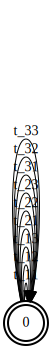

In [2]:
P = fst.Fst()
P.add_state()
P.set_start(0).set_final(0)
for k in range(m*n):
    P.add_arc(0,fst.Arc(k+1,k+1,0,0))
P.set_input_symbols(syms).set_output_symbols(syms).arcsort()

## Model of the Desired Language $K$ 

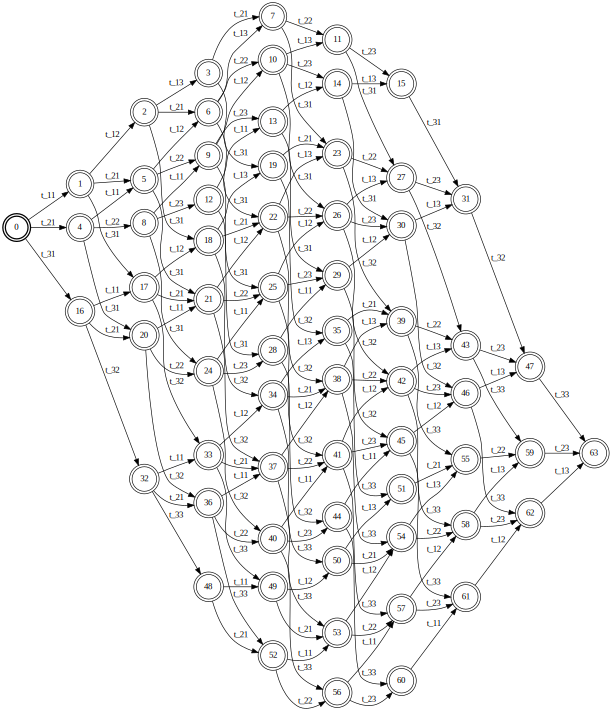

In [3]:
MK = fst.Fst()
for k in range((m+1)**n):
    MK.set_final(MK.add_state())
MK.set_start(0)

for s in range((m+1)**n):
    q = s
    for d in range(n):
        r = q % (m+1)
        if r < m:
            t = s + (m+1)**d
            l = r + m*d + 1
            MK.add_arc(s,fst.Arc(l,l,0,t))
        q = q // (m+1)
        
MK.set_input_symbols(syms).set_output_symbols(syms).arcsort()

## Output Attacker $\mathcal{A}_O$

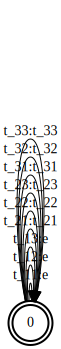

In [4]:
AO = fst.Fst()
AO.add_state()
AO.set_final(0).set_start(0)
for i in range(n):
    for j in range(m):
        il = j + m*i + 1
        ol = il if i else 0
        AO.add_arc(0,fst.Arc(il,ol,0,0))
        
AO.set_input_symbols(syms).set_output_symbols(syms).arcsort()

## Input Attacker $\mathcal{A}_{I}$

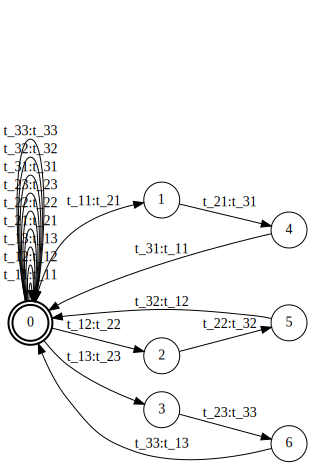

In [5]:
AI = fst.Fst()
for s in range((n-1)*m+1):
    AI.add_state()
#     AI.set_final(AI.add_state())
AI.set_start(0)
AI.set_final(0)

for j in range(m):
    t=j*(n-1)+1
    il = j + 1
    ol = il + m
    AI.add_arc(0,fst.Arc(il,ol,0,t))
    
    s=t+n-2
    ol = il
    il = j+(n-1)*m+1
    AI.add_arc(s,fst.Arc(il,ol,0,0))

for s in range(1,(n-1)*m+1):
    if (s-1)%(n-1) != n-2:
        t = s+1
        j=(s-1)//(n-1)
        i=(s-1)%(n-1)+1
        il = j + m*i + 1
        ol = il + m
        AI.add_arc(s,fst.Arc(il,ol,0,t))
    
for s in range(0,1): #(n-1)*m+1):
    for i in range(n):
        t = (i+1)%n
        for j in range(m):
            l = j + m*i + 1
            AI.add_arc(s,fst.Arc(l,l,0,s))

AI = fst.compose(AI,P)
AI.set_input_symbols(syms).set_output_symbols(syms).arcsort()

## Supervisor $\mathcal{S}$
$$
\mathcal{S} = \mathcal{A}^{-1}_0 \circ \mathcal{M}_K \circ \mathcal{A}^{-1}_I
$$

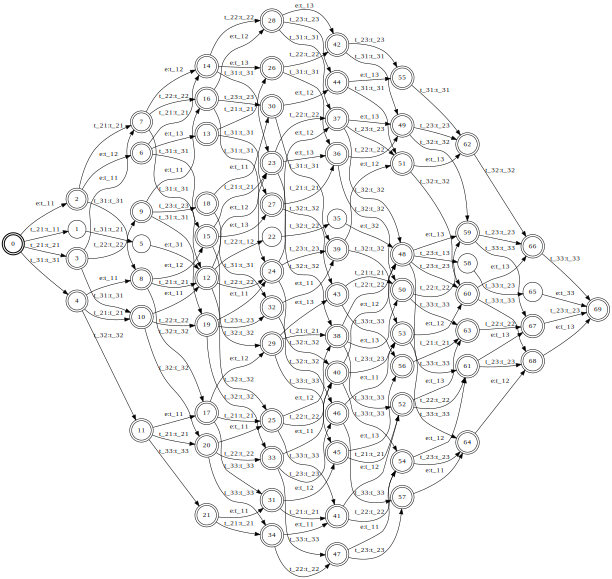

In [6]:
S = fst.compose(fst.compose(AO.copy().invert(),MK),AI.copy().invert())
S.arcsort()

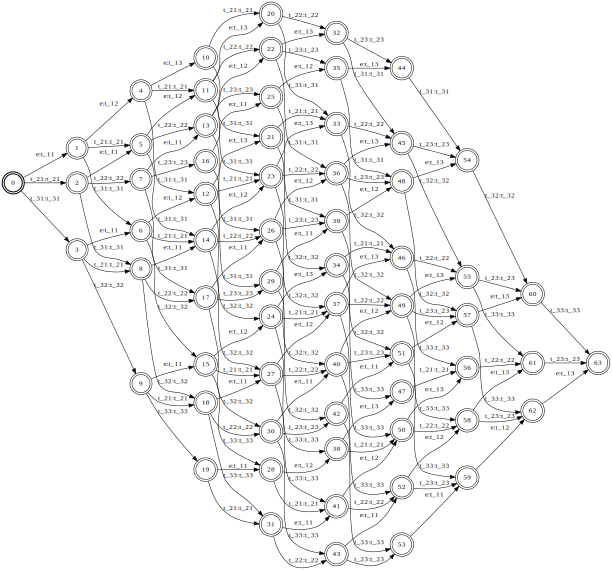

In [7]:
fst.compose(AO.copy().invert(),MK)

## Output Language $L_O(\mathcal{A}_O \circ \mathcal{S} \circ \mathcal{A}_I)$

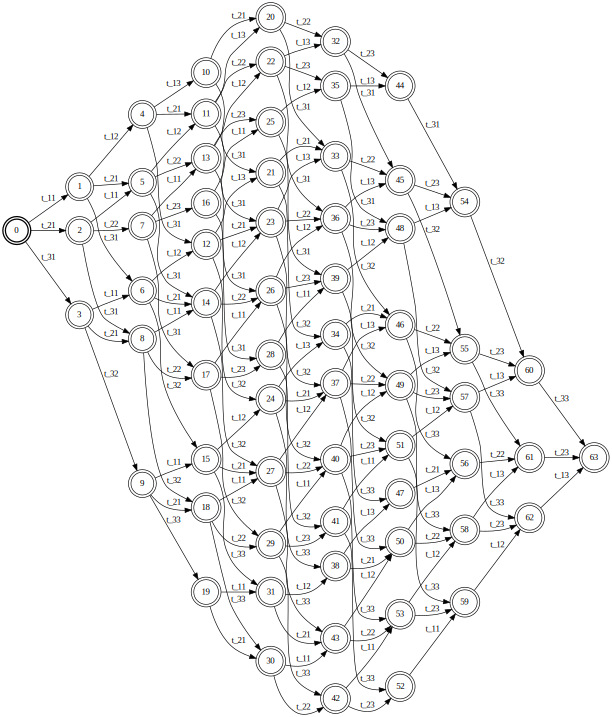

In [12]:
LO = fst.compose(fst.compose(AO,S).arcsort(),AI).project(project_output=True)
LO = fst.determinize(fst.epsnormalize(LO)).minimize()
LO.arcsort()


## Controllability $L_O(\mathcal{A}_O \circ \mathcal{S} \circ \mathcal{A}_I) \stackrel{?}{=} K$

In [9]:
K = fst.epsnormalize(MK.copy().project(project_output=True)).minimize().arcsort()
fst.equivalent(LO,K)

True